In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mon-reader/images/training/notflip/0036_000000026.jpg
/kaggle/input/mon-reader/images/training/notflip/0044_000000017.jpg
/kaggle/input/mon-reader/images/training/notflip/0004_000000024.jpg
/kaggle/input/mon-reader/images/training/notflip/0035_000000029.jpg
/kaggle/input/mon-reader/images/training/notflip/0041_000000005.jpg
/kaggle/input/mon-reader/images/training/notflip/0032_000000024.jpg
/kaggle/input/mon-reader/images/training/notflip/0005_000000004.jpg
/kaggle/input/mon-reader/images/training/notflip/0045_000000001.jpg
/kaggle/input/mon-reader/images/training/notflip/0026_000000017.jpg
/kaggle/input/mon-reader/images/training/notflip/0057_000000025.jpg
/kaggle/input/mon-reader/images/training/notflip/0035_000000031.jpg
/kaggle/input/mon-reader/images/training/notflip/0033_000000013.jpg
/kaggle/input/mon-reader/images/training/notflip/0058_000000023.jpg
/kaggle/input/mon-reader/images/training/notflip/0041_000000031.jpg
/kaggle/input/mon-reader/images/training/notflip

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-07-19 02:34:26.989225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752892467.230085      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752892467.289186      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os

data_dir = '/kaggle/input/mon-reader/images/training/'
classes = os.listdir(data_dir)
for c in classes:
    print(f'there are {len(os.listdir(data_dir+c))} images in class {c}')

there are 1230 images in class notflip
there are 1162 images in class flip


The data set is balanced, there are comparable number of images in each class

Let's now load the images:

In [4]:
batch_size = 32
img_height = 256
img_width = 256

train_dir = '/kaggle/input/mon-reader/images/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    class_names=['notflip', 'flip'],
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dir = '/kaggle/input/mon-reader/images/testing'

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    class_names=['notflip', 'flip'],
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    class_names=['notflip', 'flip'],
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 2153 files for training.


I0000 00:00:1752892554.795157      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752892554.795981      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2392 files belonging to 2 classes.
Using 239 files for validation.
Found 597 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['notflip', 'flip']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

We can now take a look at some the images from the dataset we created:

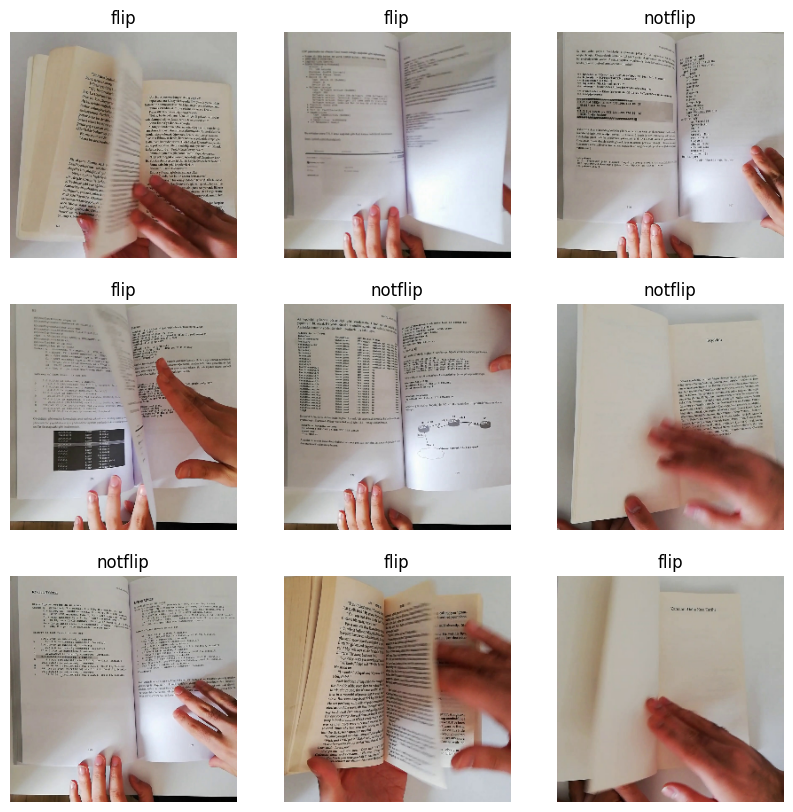

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        # print(labels.numpy())
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy().astype("uint8")[i][0]])
        plt.axis("off")

In [35]:
def to_one_hot(x, y):
    return x, tf.one_hot(y, depth=num_classes)

train_ds = train_ds.map(to_one_hot)
val_ds   = val_ds.map(to_one_hot)
test_ds  = test_ds.map(to_one_hot)

Now we can move on to craate the CNN itself:

In [11]:
from tensorflow.keras.models import Sequential

img_size = (img_height, img_width)

cnn = Sequential([
    layers.Rescaling(1./255, input_shape=(*img_size, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc-roc', curve='ROC'),
             tf.keras.metrics.AUC(name='aupr', curve='PR'),
             tf.keras.metrics.FalsePositives(name='FP'),
             tf.keras.metrics.FalseNegatives(name='FN')]
)

cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

Before training the model let's create a function to plot the metrics

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_side_by_side(history, title="Training & Validation Overview"):
    
    # Compute val-F1 from val-precision & val-recall
    p_val = np.array(history.history['val_precision'])
    r_val = np.array(history.history['val_recall'])
    f1_val = 2 * (p_val * r_val) / (p_val + r_val)

    # # Pick up the correct AUC key
    # auc_key = 'val_auc-roc' if 'val_auc-roc' in history.history else 'val_auc_roc'

    # Create side-by-side subplots
    fig, (ax_loss, ax_met) = plt.subplots(1, 2, figsize=(14, 5))

    # ─── Left: Loss ─────────────────────────────────────────────────────────
    ax_loss.plot(history.history['loss'],    marker='o', linestyle='-',  label='Train Loss')
    ax_loss.plot(history.history['val_loss'],marker='x', linestyle='--', label='Val Loss')
    ax_loss.set_title('Loss over Epochs')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.grid(alpha=0.3)
    ax_loss.legend()

    # ─── Right: Validation Metrics ───────────────────────────────────────────
    ax_met.plot(history.history['val_accuracy'], marker='o', linestyle='-',  label='Accuracy')
    ax_met.plot(r_val,                          marker='x', linestyle='--', label='Recall')
    ax_met.plot(history.history['auc-roc'],       marker='s', linestyle='-.', label='AUC-ROC')
    ax_met.plot(history.history['aupr'],       marker='*', linestyle='-.', label='AUPR')
    ax_met.plot(f1_val,                         marker='d', linestyle=':',  label='F1 Score')
    ax_met.set_title('Validation Metrics')
    ax_met.set_xlabel('Epoch')
    ax_met.set_ylim(0, 1.05)
    ax_met.grid(alpha=0.3)
    ax_met.legend(loc='lower right')

    # Overall title
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Now we can train the model:

In [13]:
history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15


I0000 00:00:1752892780.891121     105 service.cc:148] XLA service 0x7bb57800dcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752892780.892400     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752892780.892429     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752892781.633788     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/68 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - FN: 18.5000 - FP: 2.0000 - accuracy: 0.5859 - auc-roc: 0.4661 - aupr: 0.3360 - loss: 3.1896 - precision: 0.0000e+00 - recall: 0.0000e+00  

I0000 00:00:1752892788.648090     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 302ms/step - FN: 326.7536 - FP: 178.8116 - accuracy: 0.5457 - auc-roc: 0.5401 - aupr: 0.4994 - loss: 1.2698 - precision: 0.5134 - recall: 0.4150 - val_FN: 81.0000 - val_FP: 1.0000 - val_accuracy: 0.6569 - val_auc-roc: 0.7900 - val_aupr: 0.8182 - val_loss: 0.6210 - val_precision: 0.9714 - val_recall: 0.2957
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - FN: 200.4203 - FP: 107.3043 - accuracy: 0.6989 - auc-roc: 0.7644 - aupr: 0.7518 - loss: 0.5855 - precision: 0.7707 - recall: 0.5512 - val_FN: 21.0000 - val_FP: 10.0000 - val_accuracy: 0.8703 - val_auc-roc: 0.9487 - val_aupr: 0.9497 - val_loss: 0.2946 - val_precision: 0.9038 - val_recall: 0.8174
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - FN: 105.8986 - FP: 66.2464 - accuracy: 0.8313 - auc-roc: 0.9074 - aupr: 0.9085 - loss: 0.3851 - precision: 0.8623 - recall: 0.7713 - val_FN: 2.0000 - val_FP: 18.0000 - val_accuracy: 0.9163 - val_auc-roc: 0.9898 - val_aupr: 0.9893 - val_loss: 0.2427 - val_prec

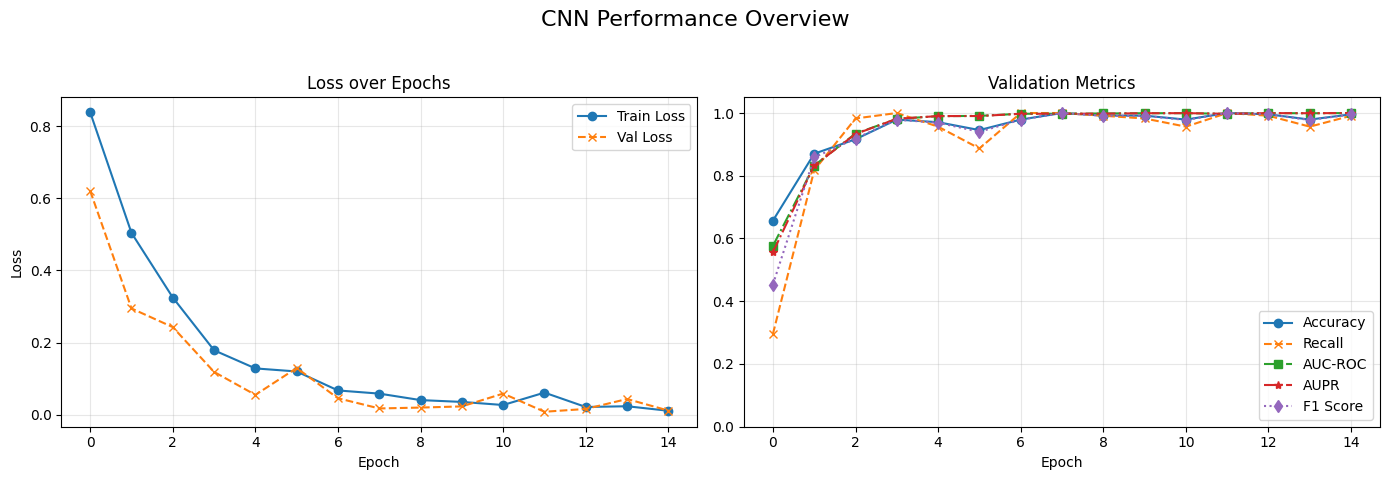

In [16]:
plot_side_by_side(history_cnn, "CNN Performance Overview")

Looking at the graphs, we can see that loss has gone down as the model learned, and we trained it sufficiently, the loss and ,etrics both are converging

In [24]:
test_scores = cnn.evaluate(test_ds, verbose=2, return_dict=True)
for name, value in test_scores.items():
    print(f"{name:15s}: {value:.4f}")

test_recall = test_scores.get('recall')
test_precision = test_scores.get('precision')
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"{'F1 score':15s}: {test_f1:.4f}")

19/19 - 0s - 20ms/step - FN: 6.0000 - FP: 1.0000 - accuracy: 0.9883 - auc-roc: 0.9979 - aupr: 0.9986 - loss: 0.0383 - precision: 0.9965 - recall: 0.9793
FN             : 6.0000
FP             : 1.0000
accuracy       : 0.9883
auc-roc        : 0.9979
aupr           : 0.9986
loss           : 0.0383
precision      : 0.9965
recall         : 0.9793
F1 score       : 0.9878


Performance on test set is also on the same level as the validation set, no overfitting

Now let's look deeper into the model, plotting ROC curve and looking at confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


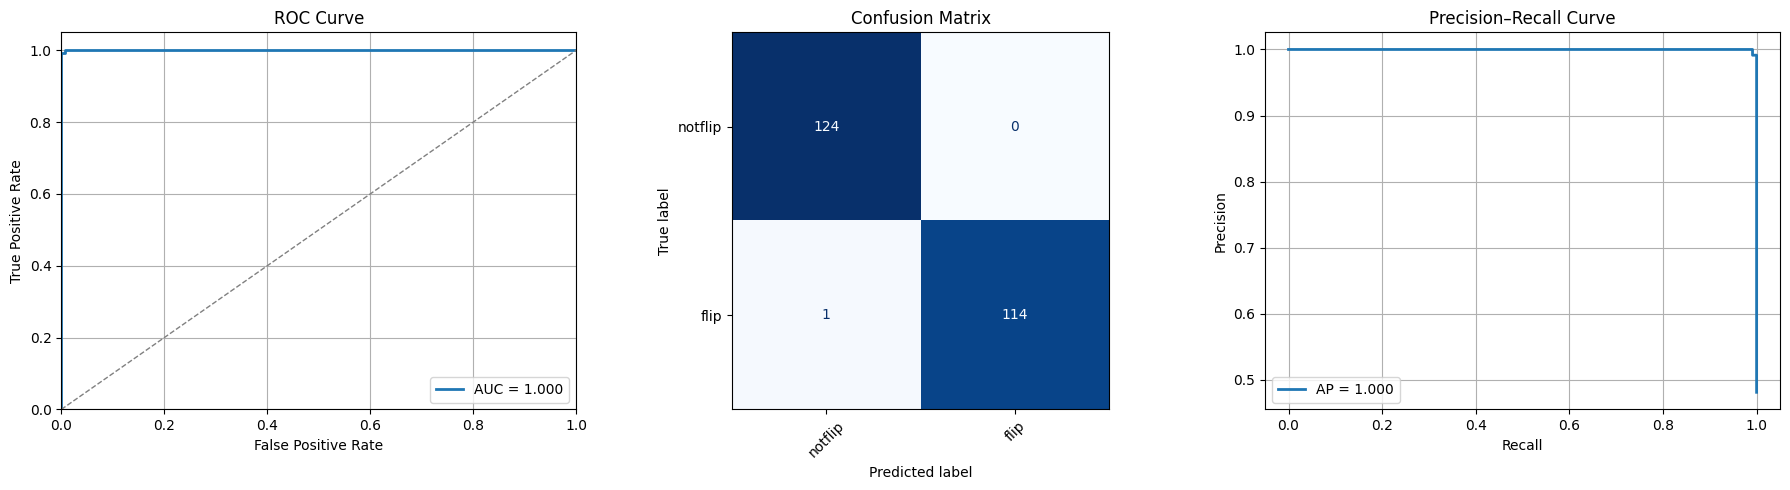

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)

y_true = []
y_score = []
for images, labels in val_ds:              # or test_ds
    probs = cnn.predict(images).ravel()    # shape (batch,) after sigmoid
    y_true.extend(labels.numpy())
    y_score.extend(probs)
y_true  = np.array(y_true)
y_score = np.array(y_score)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc     = auc(fpr, tpr)

# Confusion Matrix at 0.5 threshold
y_pred = (y_score >= 0.5).astype(int)
cm     = confusion_matrix(y_true, y_pred)
disp   = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Precision–Recall
precision, recall, _ = precision_recall_curve(y_true, y_score)
avg_prec            = average_precision_score(y_true, y_score)

# make three side-by-side subplots
fig, (ax_roc, ax_cm, ax_pr) = plt.subplots(1, 3, figsize=(18, 5))

# ─── ROC Curve ───────────────────────────────────────────────────────────────
ax_roc.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
ax_roc.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curve")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# ─── Confusion Matrix ────────────────────────────────────────────────────────
disp.plot(ax=ax_cm, cmap=plt.cm.Blues, values_format='d', colorbar=False)
ax_cm.set_title("Confusion Matrix")
ax_cm.set_xticklabels(class_names, rotation=45)
ax_cm.set_yticklabels(class_names)

# ─── Precision–Recall Curve ─────────────────────────────────────────────────
ax_pr.plot(recall, precision, lw=2, label=f"AP = {avg_prec:.3f}")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Precision–Recall Curve")
ax_pr.legend(loc="lower left")
ax_pr.grid(True)

plt.tight_layout()
plt.show()

In [13]:
from datasets import load_dataset

train_dir = "/kaggle/input/mon-reader/images/training/"
test_dir = "/kaggle/input/mon-reader/images/testing/"

ds = load_dataset(
    "imagefolder",
    data_dir="/kaggle/input/mon-reader/images/training",  # root containing 'training/' & 'test/'
    split=None
)
print(ds)

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2392
    })
})


In [14]:
from datasets import load_dataset

# ds = load_dataset(
#     "imagefolder",
#     data_dir="/kaggle/input/mon-reader/images",
#     split={
#         "train":      "training[:80%]",
#         "validation": "training[80%:]",
#         "test":       "testing"    
#     }
# )

# print(ds)

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/597 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

ValueError: Unknown split "training". Should be one of ['train', 'test'].

In [20]:
from datasets import load_dataset

# 1) Tell the ImageFolder builder exactly where to find your images
data_files = {
    "train": "/kaggle/input/mon-reader/images/training/*/*",
    "test":  "/kaggle/input/mon-reader/images/testing/*/*"
}

dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
    cache_dir="/tmp/hf_cache"
)

print(dataset)  

print("Classes:", dataset["train"].features["label"].names)
# e.g. ['flipping', 'not_flipping']

split = dataset["train"].train_test_split(test_size=0.5, seed=42)

train_ds      = split["train"]
validation_ds = split["test"]
test_ds       = dataset["test"]

print("→ train rows:",      len(train_ds))
print("→ validation rows:", len(validation_ds))
print("→ test rows:",       len(test_ds))

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/597 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2392
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 597
    })
})
Classes: ['flip', 'notflip']
→ train rows: 1196
→ validation rows: 1196
→ test rows: 597
